In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [3]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [4]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [5]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [6]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [7]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1239, 20, 1) Y.shape (1239, 1)


In [8]:
### try autoregressive RNN model
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        out, _ = self.rnn(X, (h0, c0))

        # we only want h(T) at the final time step
        out = self.fc(out[:, -1, :])
        return out

In [9]:
model = RNN(1, 5, 1, 1)

In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)

mps


RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [12]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Save losses
        train_losses[it] = loss.item()

        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

In [13]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [14]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [15]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.3590, Test Loss: 1.8242
Epoch 10/200, Train Loss: 0.1108, Test Loss: 0.2377
Epoch 15/200, Train Loss: 0.0981, Test Loss: 0.4042
Epoch 20/200, Train Loss: 0.0616, Test Loss: 0.7801
Epoch 25/200, Train Loss: 0.0280, Test Loss: 0.5275
Epoch 30/200, Train Loss: 0.0151, Test Loss: 0.2519
Epoch 35/200, Train Loss: 0.0096, Test Loss: 0.1102
Epoch 40/200, Train Loss: 0.0067, Test Loss: 0.0583
Epoch 45/200, Train Loss: 0.0073, Test Loss: 0.0519
Epoch 50/200, Train Loss: 0.0071, Test Loss: 0.0382
Epoch 55/200, Train Loss: 0.0062, Test Loss: 0.0327
Epoch 60/200, Train Loss: 0.0063, Test Loss: 0.0367
Epoch 65/200, Train Loss: 0.0059, Test Loss: 0.0323
Epoch 70/200, Train Loss: 0.0059, Test Loss: 0.0302
Epoch 75/200, Train Loss: 0.0058, Test Loss: 0.0295
Epoch 80/200, Train Loss: 0.0057, Test Loss: 0.0316
Epoch 85/200, Train Loss: 0.0056, Test Loss: 0.0327
Epoch 90/200, Train Loss: 0.0055, Test Loss: 0.0305
Epoch 95/200, Train Loss: 0.0055, Test Loss: 0.0289
Epoch 100/200

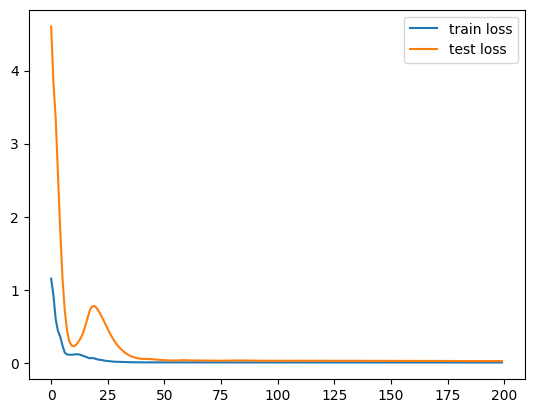

In [16]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [17]:
# One-step forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
    input_ = X_on_device[i].reshape(1, T, 1)
    p = model(input_)[0,0].item() # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

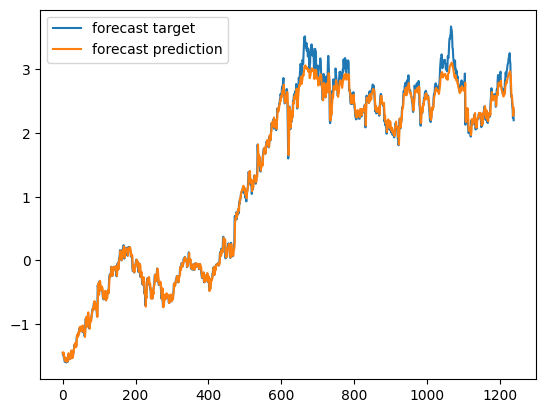

In [18]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [19]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

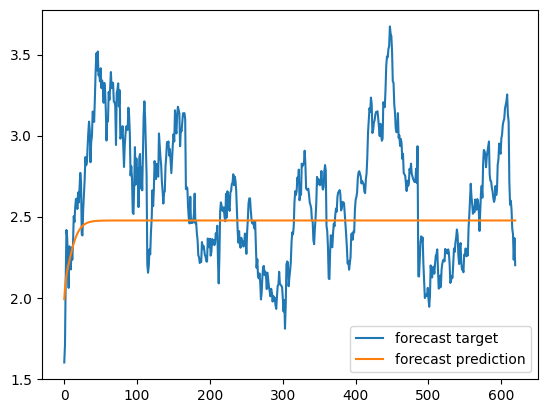

In [20]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

### PART2 : RETURNS

In [21]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [22]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [23]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [24]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


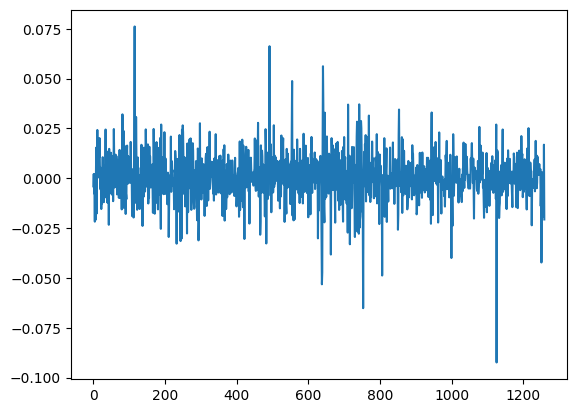

In [25]:
plt.plot(df['Return']);

<Axes: >

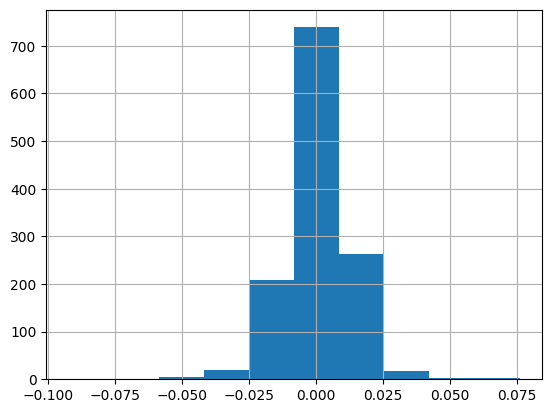

In [26]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [34]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [35]:
type(series)

numpy.ndarray

In [36]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1238, 20, 1) Y.shape (1238, 1)


In [37]:
### try autoregressive RNN model
model = RNN(1, 5, 1, 1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [38]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [39]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [40]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [41]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 1.0529, Test Loss: 1.0724
Epoch 10/200, Train Loss: 1.0542, Test Loss: 1.0809
Epoch 15/200, Train Loss: 1.0508, Test Loss: 1.0748
Epoch 20/200, Train Loss: 1.0485, Test Loss: 1.0701
Epoch 25/200, Train Loss: 1.0474, Test Loss: 1.0697
Epoch 30/200, Train Loss: 1.0451, Test Loss: 1.0723
Epoch 35/200, Train Loss: 1.0432, Test Loss: 1.0764
Epoch 40/200, Train Loss: 1.0413, Test Loss: 1.0771
Epoch 45/200, Train Loss: 1.0395, Test Loss: 1.0766
Epoch 50/200, Train Loss: 1.0380, Test Loss: 1.0798
Epoch 55/200, Train Loss: 1.0365, Test Loss: 1.0823
Epoch 60/200, Train Loss: 1.0346, Test Loss: 1.0816
Epoch 65/200, Train Loss: 1.0325, Test Loss: 1.0838
Epoch 70/200, Train Loss: 1.0303, Test Loss: 1.0859
Epoch 75/200, Train Loss: 1.0278, Test Loss: 1.0880
Epoch 80/200, Train Loss: 1.0247, Test Loss: 1.0919
Epoch 85/200, Train Loss: 1.0209, Test Loss: 1.0950
Epoch 90/200, Train Loss: 1.0163, Test Loss: 1.0993
Epoch 95/200, Train Loss: 1.0113, Test Loss: 1.1039
Epoch 100/200

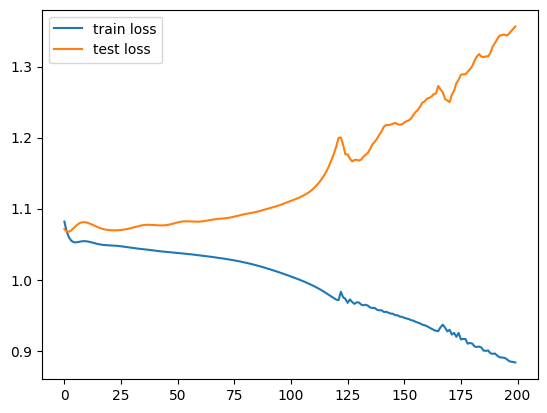

In [44]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [42]:
# One-step forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
    input_ = X_on_device[i].reshape(1, T, 1)
    p = model(input_)[0,0].item() # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

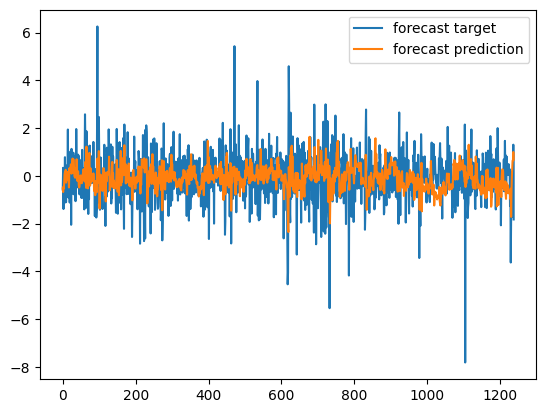

In [43]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [45]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

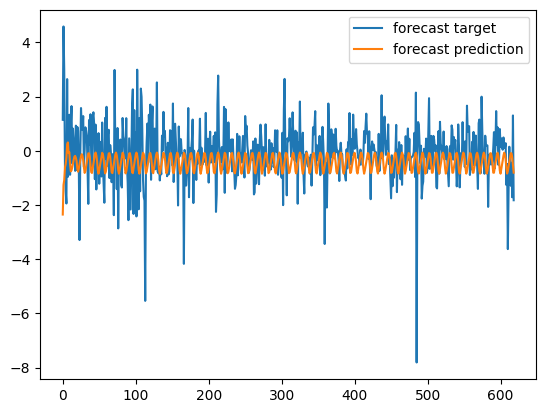

In [46]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

### Part 3: Binary Classification

In [47]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [48]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [49]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [50]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
    X_train[t, :, :] = input_data[t:t+T]
    Y_train[t] = (targets[t+T] > 0)

In [51]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):
    # u counts from 0...(N - Ntrain)
    # t counts from Ntrain...N
    t = u + Ntrain
    X_test[u, :, :] = input_data[t:t+T]
    Y_test[u] = (targets[t+T] > 0)

In [52]:
# make the RNN
model = RNN(5, 50, 2, 1)
model.to(device)

RNN(
  (rnn): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [53]:

# Loss and optimizer - it's classification now!
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [54]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

In [55]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [56]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=300)

Epoch 5/300, Train Loss: 0.6920, Test Loss: 0.6969
Epoch 10/300, Train Loss: 0.6910, Test Loss: 0.6935
Epoch 15/300, Train Loss: 0.6887, Test Loss: 0.6949
Epoch 20/300, Train Loss: 0.6843, Test Loss: 0.6966
Epoch 25/300, Train Loss: 0.6798, Test Loss: 0.6946
Epoch 30/300, Train Loss: 0.6704, Test Loss: 0.7051
Epoch 35/300, Train Loss: 0.6573, Test Loss: 0.7035
Epoch 40/300, Train Loss: 0.6407, Test Loss: 0.7110
Epoch 45/300, Train Loss: 0.6268, Test Loss: 0.7079
Epoch 50/300, Train Loss: 0.6043, Test Loss: 0.7215
Epoch 55/300, Train Loss: 0.5755, Test Loss: 0.7323
Epoch 60/300, Train Loss: 0.5519, Test Loss: 0.7512
Epoch 65/300, Train Loss: 0.5059, Test Loss: 0.7997
Epoch 70/300, Train Loss: 0.4880, Test Loss: 0.8357
Epoch 75/300, Train Loss: 0.4419, Test Loss: 0.8858
Epoch 80/300, Train Loss: 0.4047, Test Loss: 0.9242
Epoch 85/300, Train Loss: 0.3726, Test Loss: 0.9658
Epoch 90/300, Train Loss: 0.3356, Test Loss: 1.0266
Epoch 95/300, Train Loss: 0.3023, Test Loss: 1.0440
Epoch 100/300

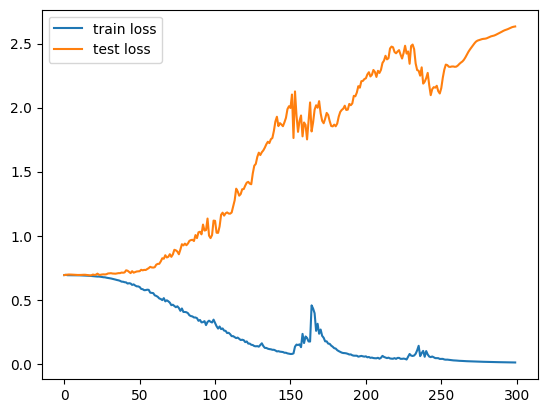

In [57]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [58]:
# Get accuracy
with torch.no_grad():
    p_train = model(X_train)
    p_train = (p_train.cpu().numpy() > 0)
    train_acc = np.mean(y_train.cpu().numpy() == p_train)

    p_test = model(X_test)
    p_test = (p_test.cpu().numpy() > 0)
    test_acc = np.mean(y_test.cpu().numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9964, Test acc: 0.4976
